In [29]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

'''
from google.colab import drive
drive.mount('/content/drive')
'''

# Set some parameters
BATCH_SIZE = 5 # the higher the better
IMG_WIDTH = 512 # for faster computing on kaggle
IMG_HEIGHT = 512 # for faster computing on kaggle
IMG_CHANNELS = 3

TRAIN_PATH = '../data/sample_data/40x_magnification'
TEST_PATH = '../data/sample_data/40x_magnification'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

In [30]:
#FOR 40X
X_train = np.load('../data/processed/X_train.npy')
Y_train = np.load('../data/processed/y_train.npy')

In [31]:
#For 10x

#X_train = np.load('X_train.npy')
#Y_train = np.load('y_train.npy')

In [ ]:
#importing and splitting the data and convert to Tensors, 
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel

split_ratio = 0.8
split_idx = int(X_train.shape[0] * split_ratio)

x = X_train[:split_idx]
y = Y_train[:split_idx]
x_val = X_train[split_idx:]
y_val = Y_train[split_idx:]

test_ratio = 0.5
split_test = int(x_val.shape[0]*test_ratio)

X_test = x_val[split_test:]
#test_ids = X_test

x_val = x_val[:split_test]
y_val = y_val[:split_test]


x_train_tensor = torch.from_numpy(x).float()
y_train_tensor = torch.from_numpy(y).float()

x_val_tensor = torch.from_numpy(x_val).float()
y_val_tensor = torch.from_numpy(y_val).float()

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)


In [33]:
#Visualization FUNCTION that display a segmentation mask using custom colors
# (0 for Back, 1 for Live, 2 for Dead) 

def show_mask(mask, title=None):
    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(mask, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

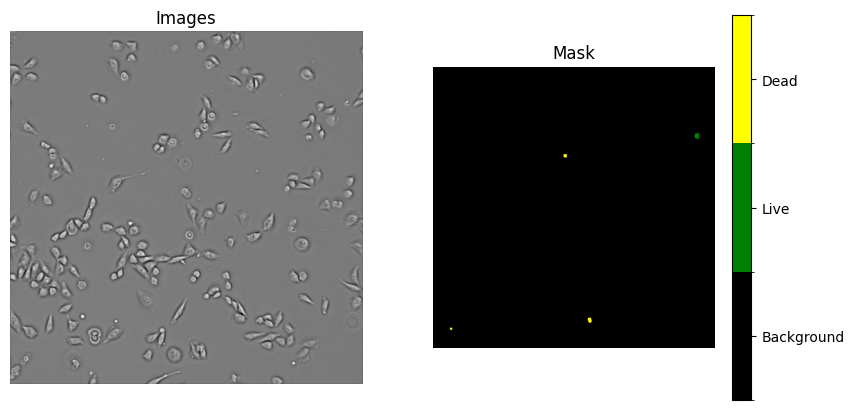

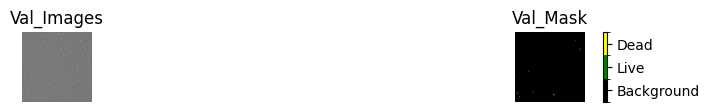

In [34]:
#Visualize Images and their corresponding masks
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x[0,:,:,0], cmap='gray')
plt.title("Images")
plt.axis('off')

plt.subplot(1, 2, 2)
show_mask(y[0],"Mask")

plt.figure(figsize=(10, 2))
plt.subplot(2, 2, 1)
plt.imshow(x_val[0,:,:,0], cmap='gray')
plt.title("Val_Images")
plt.axis('off')

plt.subplot(2, 2, 2)
show_mask(y_val[0],"Val_Mask")
#creating a training and validation generator that generate masks and images
#train_generator = zip(x, y)
#val_generator = zip(x_val, y_val)


In [ ]:
# Define IoU metric
import torch

def mean_iou(y_pred, y_true, num_classes=3):
    
    y_pred = torch.argmax(y_pred, dim=1)

    iou_list = []
    
    for class_id in range(num_classes):
       
        intersection = torch.sum((y_true == class_id) & (y_pred == class_id))
        union = torch.sum((y_true == class_id) | (y_pred == class_id))
        
        
        if union == 0:
            iou = torch.tensor(1.0)
        else:
            iou = intersection.float() / union.float()
        
        iou_list.append(iou)

    return torch.mean(torch.tensor(iou_list))

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super(ConvBlock, self).__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.conv_block(x))
        else:
            return self.conv_block(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(DownSample, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x):
        x = self.maxpool_conv(x)
        return x

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(UpSample, self).__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.out_channels = out_channels
        self.conv = nn.Sequential(
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x):

        x = self.upsample(x)
        #print(x.shape)
        #print(skip_x.shape)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        #emb = self.emb_layer(t)[:, :, None, None].expand(-1, -1, x.shape[-2], x.shape[-1])
        return x

class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3):
        super(UNet, self).__init__()
        self.initial_conv = ConvBlock(c_in, 64)
        self.downsample1 = DownSample(64, 128)
        self.downsample2 = DownSample(128, 256)
        self.downsample3 = DownSample(256, 256)

        self.bottom1 = ConvBlock(256, 512)
        self.bottom2 = ConvBlock(512, 512)
        self.bottom3 = ConvBlock(512, 256)

        self.upsample1 = UpSample(512, 128)
        self.upsample2 = UpSample(256, 64)
        self.upsample3 = UpSample(128, 64)
        
        self.output_conv = nn.Conv2d(64, c_out, kernel_size=1)
        self.output_ex1 = nn.Conv2d(128, c_out, kernel_size=1)
        self.output_ex2 = nn.Conv2d(512, c_out, kernel_size=1)
        self.output_ex3 = nn.Conv2d(128, c_out, kernel_size=1)

    def forward(self, x):

        x1 = self.initial_conv(x)
        x2 = self.downsample1(x1)
        ex1 = x2
        ex1 = self.output_ex1(ex1)
        
        x3 = self.downsample2(x2)
        x4 = self.downsample3(x3)
        

        x4 = self.bottom1(x4)
        ex2 = x4
        ex2 = self.output_ex2(ex2)
        
        x4 = self.bottom2(x4)
        x4 = self.bottom3(x4)

        x = self.upsample1(x4, x3)
        ex3 = x
        ex3 = self.output_ex3(ex3)
        
        x = self.upsample2(x, x2)
        x = self.upsample3(x, x1)
        output = self.output_conv(x)
        
        return output,ex1,ex2,ex3

In [37]:
#define early stopping if validation loss doesn't improve for multiple epochs
class EarlyStopping:
    def __init__(self, patience=3, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, model):
        if self.verbose:
            print(f'Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pth')


In [ ]:
import torch.backends.cudnn as cudnn

c_in = 3  # input channel 3 for RGB
c_out = 3  # output channel
if torch.cuda.device_count() >= 1:
    device1 = torch.device("cuda:0")
    device2 = torch.device("cuda:1")
else:
    raise RuntimeError("Multiple GPUs are required.")

model = UNet(c_in, c_out)
checkpoint = torch.load('../weights/checkpoint.pth')
modified_state_dict = {key.replace('module.', ''): value for key, value in checkpoint.items()}
model.load_state_dict(modified_state_dict)
cudnn.benchmark = True
model = torch.nn.DataParallel(model)

class ThreeChannelLogitsLoss(nn.Module):
    def __init__(self):
        super(ThreeChannelLogitsLoss, self).__init__()

    def forward(self, output, target):
        loss = 0
        for i in range(c_out):
            loss += nn.BCEWithLogitsLoss()(output[:, i, :, :], target[:, i, :, :])
        return loss / c_out
   
criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=10, verbose=True)
scheduler =  torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)


In [ ]:

# Training loop
num_epochs = 100
model.to(device1)
best_loss = 1.0
best_iou = 0.0
log_file = open("training_log.txt", "w")


for epoch in range(0,num_epochs):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    print("first for loop")
    for i,(inputs, labels) in enumerate(tqdm(train_loader)): #Loop over training data
        gpu = torch.cuda.get_device_properties(device1)
        #print(f'{device1}: {gpu.name}, Total Memory: {gpu.total_memory / 1024**2:.2f} MB, Free Memory: {torch.cuda.max_memory_allocated(device1) / 1024**2:.2f} MB')
        #print(torch.cuda.memory_allocated(device1))
        #print(torch.cuda.max_memory_allocated(device1))
        if torch.cuda.memory_allocated(device1) > 0.9 * gpu.total_memory:
            model = model.to(device2)
            device1, device2 = device2, device1
            print('changed gpu')
            #inputs, labels = inputs.to(device1), labels.to(device1)
            model = model.to(device1)
            
        # labels = labels.unsqueeze(-1) 
        inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
        #print(inputs.shape)
        #print(labels.shape)
        optimizer.zero_grad()
        outputs,_,_,_ = model(inputs)
        labels = labels.squeeze(1)
        iou = mean_iou(outputs, labels)
        labels = labels.long()
        # print(f"Min label value: {labels.min()}, Max label value: {labels.max()}")

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_iou += iou.item()

        if i % 50 == 0 and i != 0:
            print(f"Epoch {epoch+1}: Batch[{i}/{len(train_loader)}] Loss: {total_loss / i} IoU: {total_iou / i}")
            if i % 100 == 0:
                print(f'Saving model...')
                torch.save(model.state_dict(), 'checkpoint.pth')
    avg_loss = total_loss / len(train_loader)
    avg_iou = total_iou / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss} IoU: {avg_iou}")

    best_loss = min(best_loss,avg_loss)
    best_iou = max(best_iou,avg_iou)
    
    if best_iou-avg_iou > 0.1:
        print("Model Overfit")
        break
    

    log_file.write(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss} IoU: {avg_iou}\n")
    log_file.write(f'Best loss: {best_loss}, Best IoU: {best_iou}\n\n')
    log_file.flush()

    if early_stopping(avg_loss, model):
        print('Early stopping triggered')
        break
    
# torch.save(model.state_dict(), 'model.pth')
print(f'Best loss is {best_loss}, best iou is {best_iou}')


In [44]:
model = model.to(device1)
model.eval()
total_val_loss = 0.0
total_val_iou = 0.0
num_batches = len(val_loader)

with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
        outputs = model(inputs)
        labels = labels.squeeze(1)
        total_val_iou += mean_iou(outputs, labels).item()
        labels = labels.long()
        loss = criterion(outputs, labels)
        total_val_loss += loss.item()
        
preds_val = outputs

avg_val_loss = total_val_loss / num_batches
avg_val_iou = total_val_iou / num_batches

print(f"Validation Loss: {avg_val_loss}, Validation IoU: {avg_val_iou}")


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

Validation Loss: 0.08240874111652374, Validation IoU: 0.3303951919078827


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

model = model.to(device1)
model.eval()
total_val_loss = 0.0
total_val_iou = 0.0
num_batches = len(val_loader)

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        # Add channel dimension to labels if needed
        # labels = labels.unsqueeze(-1)
        
        # Permute inputs and labels for model compatibility
        inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
        
        # Get model outputs and calculate IoU
        outputs,_,_,_ = model(inputs)
        labels = labels.squeeze(1)  # Remove the channel dimension for evaluation
        
        total_val_iou += mean_iou(outputs, labels).item()
        labels = labels.long()
        
        # Calculate loss
        loss = criterion(outputs, labels)
        total_val_loss += loss.item()
        
        # Convert model outputs to predicted labels
        preds = torch.argmax(outputs, dim=1)  # Get the predicted class for each pixel
        
        # Append to the lists for metric calculation
        all_preds.append(preds.cpu().numpy().flatten())
        all_labels.append(labels.cpu().numpy().flatten())

# Flatten the lists to create 1D arrays for metric calculation
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

avg_val_loss = total_val_loss / num_batches
avg_val_iou = total_val_iou / num_batches

# Print metrics
print(f"Validation Loss: {avg_val_loss}")
print(f"Validation IoU: {avg_val_iou}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

Validation Loss: 0.08240874111652374
Validation IoU: 0.3303951919078827
Precision: 0.9961033721385202
Recall: 0.9909019470214844
F1 Score: 0.993495851640691


In [ ]:
model = model.to(device1)
model.eval()
# with torch.no_grad():
#     for inputs in tqdm(val_loader):
#         inputs = inputs[0].permute(0, 3, 1, 2).to(device2)
#         outputs = model(inputs)
        #print(outputs.shape)
#torch.save(model.state_dict(),'cell_segment.pth')
#prediction
#X_train = torch.Tensor(X_train).permute(0, 3, 1, 2).to(device)
#model=model.to(device1)
preds_val=[]
preds_test=[]

# X_test = torch.Tensor(X_test).permute(0, 3, 1, 2)
# val_X = x_val_tensor.permute(0,3,1,2)
X_test_tensor = torch.tensor(X_test).permute(0, 3, 1, 2)
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

with torch.no_grad():
    #preds_train = model(X_train[:int(X_train.shape[0]*0.9)])
    #preds_val = model(X_train[int(X_train.shape[0]*0.9):])
    #preds_train = model(x_train_tensor.permute(0,3,1,2).to(device2))
    # preds_val = model(val_X[:int(val_X.shape[0]*0.06)].to(device2))
    # preds_test = model(X_test[:int(X_test.shape[0]*0.06)].to(device2))
    # preds_val = model(val_X.to(device1))
    # preds_test = model(X_test.to(device1))
    for inputs, labels in tqdm(val_loader):
        # labels = labels.unsqueeze(-1)
        inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
        outputs,_,_,_ = model(inputs)
        preds_val.append(outputs)

    for batch in tqdm(test_loader):
        inputs = batch[0].to(device1).float()
        outputs,_,_,_ = model(inputs)
        preds_test.append(outputs)
        

#print(preds_test[0].size())
# # Threshold predictions
# threshold = 0.5
# #preds_train_t = (preds_train > threshold).byte()
# preds_val_t = (preds_val > threshold)
# preds_test_t = (preds_test > threshold)

# # Create a list of upsampled test masks
# preds_test_upsampled = []
# for i in range(len(preds_test)):
#     preds_test_upsampled.append(np.squeeze(preds_test_t[i]))
    


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]
